In [1]:
#import sklearn
import scipy
#import skimage
import pandas
import numpy as np
from PIL import Image
#import bokeh
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
#%matplotlib inline
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
#matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models

## Torchvision
import torchvision
from torchvision import transforms

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
#%load_ext tensorboard

from tensorboard.plugins import projector

import cv2
import pathlib
import os
import datetime
#import tensorflow as tf

from os import listdir, walk
from os.path import isfile, join


from os import listdir, walk
from os.path import isfile, join

#import wandb
import random

<Figure size 432x288 with 0 Axes>

In [2]:
#IMPORT TEST FILES

data_path_test = "/gpfs/data/fs71186/kadic/Herbarium_2022/test_images"

test_image_files = [join(dirpath,f) for (dirpath, dirnames, filenames) in walk(data_path_test) for f in filenames] 

print(len(test_image_files))

test_image_files = sorted(test_image_files)

ground_truths = "/gpfs/data/fs71186/kadic/Herbarium_2022/test_metadata.json"

import json
 
# Opening JSON file
f = open(ground_truths)
 
# returns JSON object as
# a dictionary
ground_truth_data = json.load(f)
print(type(ground_truth_data))
f.close()

image_ids = {}

for i, img_path in enumerate(test_image_files):
    image_ids["img_path"] = ground_truth_data[i]["image_id"]
    if(i%100000 == 0):
        print(img_path)
        print(ground_truth_data[i]["file_name"])

210407
<class 'list'>
/gpfs/data/fs71186/kadic/Herbarium_2022/test_images/000/test-000000.jpg
000/test-000000.jpg
/gpfs/data/fs71186/kadic/Herbarium_2022/test_images/106/test-106317.jpg
106/test-106317.jpg
/gpfs/data/fs71186/kadic/Herbarium_2022/test_images/212/test-212616.jpg
212/test-212616.jpg


In [ ]:
wrong_keys = []
missing_keys = []

for key in diff_annot.keys():
    if(key < 0 or key > 15500):
        print("wrong_key: " + str(key))
        wrong_keys.append(key)

for i in range(0,15501):
    if(i not in diff_annot.keys()):
        missing_keys.append(i)

print(len(wrong_keys))
print(len(missing_keys))

In [4]:
print(os.path.basename(test_image_files[0]))

test-068720.jpg


In [4]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = ""
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models/contrastive_models"
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

[rank: 0] Global seed set to 42


Device: cuda:0
Number of workers: 32


In [5]:
class TestImageDataset(Dataset):
    def __init__(self, paths,transform):
        self.paths = [i[0] for i in paths]
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        image_path = self.paths[index]
        image_l = Image.open(image_path)
        image = image_l.convert('RGB')
        image_tensor = image
        if self.transform:
            image_tensor = self.transform(image)
        
        return image_tensor

In [6]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

In [8]:
model_15 = "../saved_models/contrastive_models/15_SIM_CLR_VAL/lightning_logs/version_1607025/checkpoints/epoch=202-step=1977423.ckpt"

In [9]:
pretrained_filename = model_15
    
simclr_model = SimCLR.load_from_checkpoint(pretrained_filename)

print(type(simclr_model))

<class '__main__.SimCLR'>


In [10]:
class LogisticRegression(pl.LightningModule):

    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=1000):
        super().__init__()
        # Mapping from representation h to classes
        self.save_hyperparameters()
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs*0.6),
                                                                  int(self.hparams.max_epochs*0.8)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        feats, labels = batch
        preds = self.model(feats)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        
        wandb.log({"acc": acc, "loss": loss})
        
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

In [11]:
img_transforms = transforms.Compose([transforms.Resize((500, 333)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

In [ ]:
test_img_data = TestImageDataset(test_files, transform = img_transforms)

In [12]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats = []
    for batch_imgs in tqdm(data_loader):
        #print(len(batch_imgs))
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())

    feats = torch.cat(feats, dim=0)

    return data.TensorDataset(feats)

# FULL PREDICTIONS CODE

In [ ]:
test_feats_simclr = prepare_data_features(simclr_model, test_img_data)

In [ ]:
model_14_logreg = "./saved_models/contrastive_models/LogisticRegression/lightning_logs/version_1614704/checkpoints/epoch=609-step=8004420.ckpt"

pretrained_filename = model_14_logreg

if os.path.isfile(pretrained_filename):
    print(f"Found pretrained model at {pretrained_filename}, loading...")
    model = LogisticRegression.load_from_checkpoint(pretrained_filename)

In [ ]:
test_loader = data.DataLoader(test_feats_simclr, batch_size=batch_size, shuffle=False,
                                   drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
trainer = pl.Trainer()
predictions = trainer.predict(model, dataloaders=test_test_loader)

In [ ]:
import csv
with open("./predictions/preds_model_14", "w") as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow("Id,Predicted")
        for i,pred in enumerate(predictions):
            writer.writerow(str(i) + "," + str(pred))
        csv_file.close()

In [ ]:
import pandas as pd 
  
# read contents of csv file 
file = pd.read_csv("../predictions/preds_model_14.csv") 
  
# adding header 
headerList = ['Id', 'Predicted'] 
  
# converting data frame to csv 
file.to_csv("../predictions/preds_model_14.csv", header=headerList, index=False) 

In [3]:
frame = pandas.read_csv('../predictions/preds_model_15.csv')

sum_n = 0
dict_ress = {}
print(frame.shape)
for id_n,pred in frame.iterrows():
    if(pred[1] in dict_ress.keys()):
        dict_ress[pred[1]]+=1
    else:
        dict_ress[pred[1]]=1
#    if(pred[1] == 0):
#        sum_n+=1
#    if(pred[1] == 103):
#        sum_n+=1
#    if(pred[1]== 7000):
#        sum_n+=1
#    if(pred[1] == 9000):
#        sum_n+=1
#    if(pred[1] == 2683):
#        sum_n+=1
print(dict_ress[0])

(210407, 2)
14


In [6]:
import json
data_path_train = "/gpfs/data/fs71186/kadic/Herbarium_2022/train_images"
ground_truths_train = "/gpfs/data/fs71186/kadic/Herbarium_2022/train_metadata.json" 

train_image_files = [join(dirpath,f) for (dirpath, dirnames, filenames) in walk(data_path_train) for f in filenames] 

# Opening JSON file
f = open(ground_truths_train)
ground_truth_data_train = json.load(f)
gt_annot = ground_truth_data_train["annotations"]
f.close()

train_data = []
test_data = []

for i, img in enumerate(train_image_files):
    train_data.append((img, gt_annot[i]['category_id']))

labels = []
label_count = {}
for img, annot in train_data:
    if annot not in labels:
        labels.append(annot)
        label_count[str(annot)] = 1
    else:
        label_count[str(annot)] = int(label_count[str(annot)]) + 1
        
sorted_count = dict(sorted(label_count.items(), key=lambda item: item[1]))

biggest_500 = list(sorted_count.items())[15001:]

print(len(biggest_500))

500


In [17]:
biggest_n = list(sorted_count.items())[7000:]
print(biggest_n[0])
print(biggest_n[len(biggest_n)-1])
sum_n = 0
for cat in biggest_n:
    sum_n += dict_ress[int(cat[0])]
print(sum_n)
print(sum_n/210407)

('7016', 62)
('15390', 80)
160780
0.7641380752541503


# EXPLORE THE WRONG DATA

In [2]:
pred_model_15 = "../saved_models/contrastive_models/LogisticRegression/lightning_logs/version_1778587/checkpoints/epoch=659-step=8053980.ckpt"

test_set_path = "../test_files.npy"

In [3]:
test_set = np.load(test_set_path).tolist()

In [4]:
print(len(test_set))
print(test_set[0])

58785
['/gpfs/data/fs71186/kadic/Herbarium_2022/train_images/034/66/03466__042.jpg', '3466']


In [5]:
test_files =  []

for val in test_set:
    test_files.append(val[0])
    if(os.path.isdir(val[0])):
        print(val[0])
print(len(test_files))
    
test_img_data = TestImageDataset(test_files, transform = img_transforms)
test_feats_simclr = prepare_data_features(simclr_model, test_img_data)

In [ ]:
pretrained_filename = pred_model_15

if os.path.isfile(pretrained_filename):
    print(f"Found pretrained model at {pretrained_filename}, loading...")
    model = LogisticRegression.load_from_checkpoint(pretrained_filename)

In [ ]:
test_loader = data.DataLoader(test_feats_simclr, batch_size=batch_size, shuffle=False,
                                   drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
trainer = pl.Trainer()
predictions = trainer.predict(model, dataloaders=test_test_loader)

## START HERE WHEN WORKING

In [2]:
predictions = np.load("../REAL_preds.npy")
labels = np.load("../REAL_true_res.npy")

In [74]:
data_path_train = "/gpfs/data/fs71186/kadic/Herbarium_2022/train_images"
ground_truths = "/gpfs/data/fs71186/kadic/Herbarium_2022/train_metadata.json"

train_image_files = [join(dirpath,f) for (dirpath, dirnames, filenames) in walk(data_path_train) for f in filenames] 
train_image_files = sorted(train_image_files)

import json
f = open(ground_truths)
ground_truth_data = json.load(f)
gt_annot = ground_truth_data["annotations"]
f.close()

train_data = []
#REMOVING 4 FOR LOG REG ALGO
for i, img in enumerate(train_image_files):
    cat_id = gt_annot[i]['category_id']
    train_data.append((img, int(cat_id)))

train_image_files = [join(dirpath,f) for (dirpath, dirnames, filenames) in walk(data_path_train) for f in filenames] 

train_labels = []
label_count = {}
for img, annot in train_data:
    if annot not in train_labels:
        train_labels.append(annot)
        label_count[str(annot)] = 1
    else:
        label_count[str(annot)] = int(label_count[str(annot)]) + 1
        
sorted_count = dict(sorted(label_count.items(), key=lambda item: item[1]))

np.save("cats_sorted_train.npy", np.array(list(sorted_count.items())))


In [3]:
cats_sorted_list = np.load("cats_sorted_train.npy")
cats_sorted = {}
for v in cats_sorted_list:
    cats_sorted[str(v[0])] = int(v[1]) 

In [4]:
print(cats_sorted_list[0])

['13305' '5']


In [5]:
print(predictions[0])
print(labels[0])

preds = [int(x) for x in predictions]
for x in predictions:
    cat_id = int(x)
    if(cat_id == 103):
        cat_id = 15501
    if(cat_id == 2683):
        cat_id = 15502
    if(cat_id == 7000):
        cat_id = 15503
    if(cat_id == 9000):
        cat_id = 15504
    preds.append(cat_id)
    
labs = []
for x in labels:
    cat_id = int(x)
    if(cat_id == 103):
        cat_id = 15501
    if(cat_id == 2683):
        cat_id = 15502
    if(cat_id == 7000):
        cat_id = 15503
    if(cat_id == 9000):
        cat_id = 15504
    labs.append(cat_id)

3454
3466


In [6]:
acc = 0
i = 0
correct = []
wrong = []
for t_pred, t_label in zip(preds, labs):
    if(t_pred == t_label):
        correct.append((i, t_pred, t_label))
        acc += 1
    else:
        wrong.append((i, t_pred, t_label))
    i+=1

In [7]:
print(acc)
print(acc/len(predictions))

30665
0.5216466785744662


In [8]:
gts = np.load("../test_files.npy")
print(gts[0][1])

3466


In [9]:
print(len(correct))

30665


In [10]:
tot_cl = []

In [11]:
correct_classes = {}
wrong_classes = {}

for idx, pr, tr in correct:
    if(str(tr) in correct_classes.keys()):
        correct_classes[str(tr)] += 1
    else:
        correct_classes[str(tr)] = 1
    if(tr not in tot_cl):
        tot_cl.append(tr)
        
for idx, pr, tr in wrong:
    if(str(tr) in wrong_classes.keys()):
        wrong_classes[str(tr)] += 1
    else:
        wrong_classes[str(tr)] = 1
    if(tr not in tot_cl):
        tot_cl.append(tr)

In [12]:
print("number of diff correct classes: "+ str(len(correct_classes.keys())))
print("number of diff wrong classes: "+ str(len(wrong_classes.keys())))
print("number of total classes: "+ str(len(tot_cl)))

number of diff correct classes: 11510
number of diff wrong classes: 12002
number of total classes: 14179


In [13]:
always_right = []
always_wrong = []
for cat in correct_classes.keys():
    if cat not in wrong_classes.keys():
        always_right.append(cat)
        
for cat in wrong_classes.keys():
    if cat not in correct_classes.keys():
        always_wrong.append(cat)     

print(len(always_right))
print(len(always_wrong))

2177
2669


In [14]:
print(always_right[0])

3751


In [15]:
toto = 0
for i in range(0, len(always_right)):
    toto += correct_classes[always_right[i]]
print(toto)

5744


In [16]:
avg_r = 0
r_list = []
for v in always_right:
    #print(cats_sorted[str(v)])
    if(cats_sorted[str(v)] < 9):
        r_list.append(v)
    avg_r += cats_sorted[str(v)]
    
avg_w = 0
w_list = []
for v in always_wrong:
    #print(cats_sorted[str(v)])
    if(cats_sorted[str(v)] > 79):
        w_list.append(v)
    avg_w += cats_sorted[str(v)]

print("avg right cat size: " + str(float(avg_r/len(always_right))))
print(len(r_list))    
      
print("avg wrong cat size: " + str(float(avg_w/len(always_wrong))))      
print(len(w_list))

avg right cat size: 53.34175470831419
11
avg wrong cat size: 37.33233420756838
7


In [17]:
print(w_list)
print(r_list)

['4071', '9519', '10363', '12573', '5357', '11466', '578']
['2447', '7288', '11096', '636', '8314', '4301', '9935', '13311', '2239', '9577', '11050']


In [18]:
w_ind = []
r_ind = []
for v in w_list:
    w_ind.append(always_wrong.index(v))
for v in r_list:
    r_ind.append(always_right.index(v))
print(w_ind)
print(r_ind)

[74, 167, 774, 1088, 1572, 1709, 1710]
[758, 1023, 1214, 1461, 1578, 1837, 1843, 1867, 2080, 2143, 2171]


In [19]:
def visualize_examples(images):
    im_vis = []
    
    for im in images:
        image = torchvision.io.read_image(im)
        image = torchvision.transforms.Resize((1000, 666))(image) 
        im_vis.append(image)
        
    # Visualize some examples
    NUM_IMAGES = len(images)
    imgs = im_vis
    img_grid = torchvision.utils.make_grid(imgs)#, nrow=4, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)

    plt.figure(figsize=(20,10))
    plt.title('Same class images')
    plt.imshow(img_grid)
    plt.axis('off')
    plt.savefig('Herb_2022_192_15.png')
    plt.show()
    plt.close()
    
    return

/gpfs/data/fs71186/kadic/Herbarium_2022/train_images/110/50/11050__005.jpg


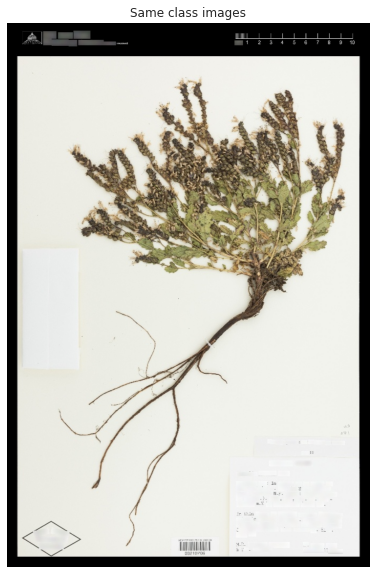

In [43]:
#[758, 1023, 1214, 1461, 1578, 1837, 1843, 1867, 2080, 2143, 2171]+
show_index = 2171
explore_images = []
for val in gts:
    if val[1]  == always_right[show_index]:
        print(val[0])
        explore_images.append(val[0])
visualize_examples(explore_images)

/gpfs/data/fs71186/kadic/Herbarium_2022/train_images/005/78/00578__050.jpg
/gpfs/data/fs71186/kadic/Herbarium_2022/train_images/005/78/00578__078.jpg
/gpfs/data/fs71186/kadic/Herbarium_2022/train_images/005/78/00578__029.jpg


/home/fs71186/kadic/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


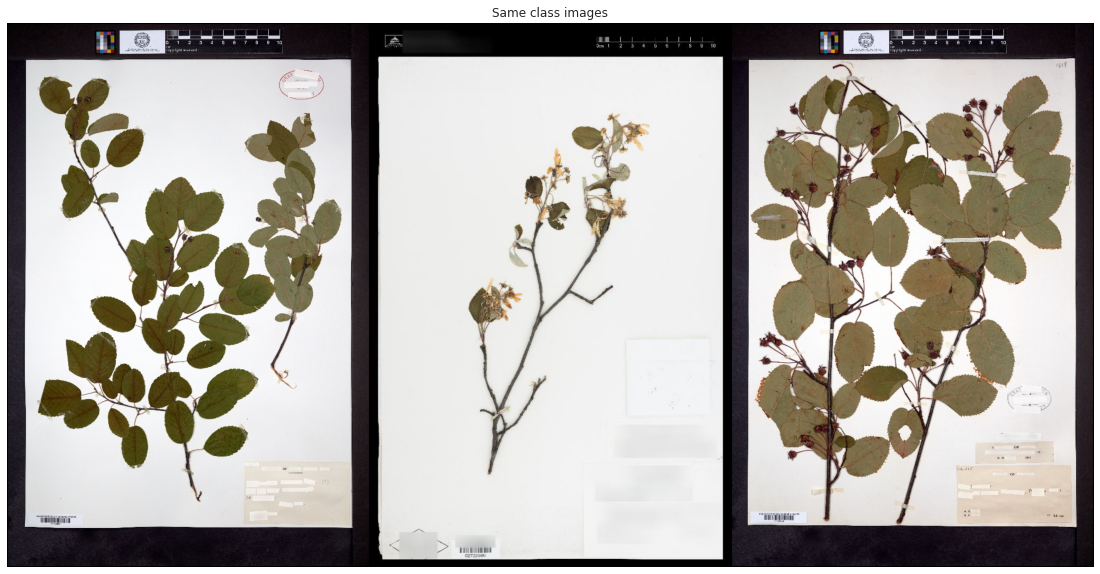

In [20]:
# [74, 167, 774, 1088, 1572, 1709, 1710]
show_index = 1710
explore_images = []
for val in gts:
    if val[1]  == always_wrong[show_index]:
        print(val[0])
        explore_images.append(val[0])
visualize_examples(explore_images)

In [24]:
#['4071', '9519', '10363', '12573', '5357', '11466', '578']
preds_w = []
print(len(wrong))
print(wrong[0])
for i, pr,lb in wrong:
    if(int(lb) == 578):
        preds_w.append(pr)
print(preds_w)

28120
(0, 3454, 3466)
[573, 569, 573]


/gpfs/data/fs71186/kadic/Herbarium_2022/train_images/005/73/00573__086.jpg
/gpfs/data/fs71186/kadic/Herbarium_2022/train_images/005/73/00573__015.jpg
/gpfs/data/fs71186/kadic/Herbarium_2022/train_images/005/73/00573__085.jpg
/gpfs/data/fs71186/kadic/Herbarium_2022/train_images/005/73/00573__014.jpg
/gpfs/data/fs71186/kadic/Herbarium_2022/train_images/005/73/00573__093.jpg


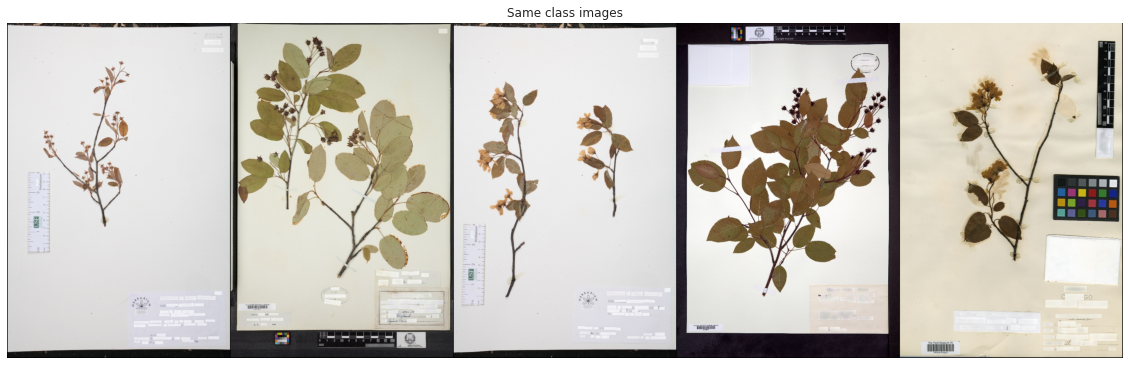

In [28]:
explore_images = []
for val in gts:
    if int(val[1])  == 573:
        print(val[0])
        explore_images.append(val[0])
visualize_examples(explore_images)

In [34]:
for i, pr,lb in correct:
    if(int(pr) == 569):
        print("1")

1
1
1
1
